# Calibration within jupyter notebooks

In [1]:
%matplotlib nbagg
import time
import pyFAI
import pyFAI.test.utilstest
import fabio
from matplotlib.pyplot import subplots
from ipywidgets import *
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.peak_picker import PeakPicker
from pyFAI.geometryRefinement import GeometryRefinement
start_time=time.perf_counter()

In [2]:
wavelength = 1e-10
pilatus = pyFAI.detector_factory("Pilatus1M")
AgBh = pyFAI.calibrant.CALIBRANT_FACTORY("AgBh")
AgBh.wavelength = wavelength

img = pyFAI.test.utilstest.UtilsTest.getimage("Pilatus1M.edf")
fimg = fabio.open(img)
image = fimg.data

<IPython.core.display.Javascript object>


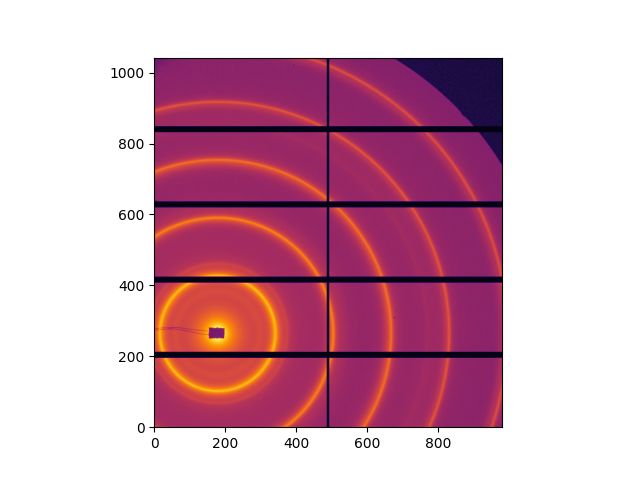

<AxesSubplot:>

In [3]:
jupyter.display(image)

1. Shift + left-click to pick a set of point 
2. Click "assign group" to the ring numner (0-based!)
then you click merge
3. Click save to expose the control points


<IPython.core.display.Javascript object>


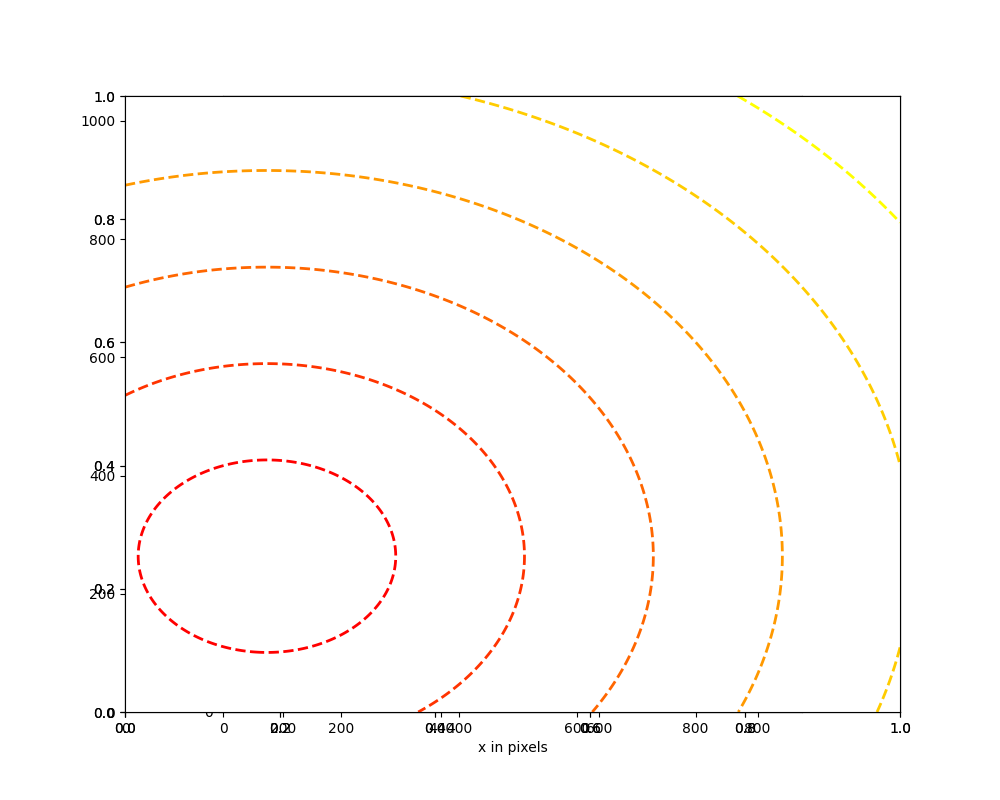

In [4]:
pp = PeakPicker(data=fimg.data, calibrant=AgBh, wavelength=wavelength, detector=pilatus)

pp.gui(log=True)

In [7]:
pp.points

ControlPoints instance containing 2 group of point:
AgBh Calibrant with 49 reflections at wavelength 1e-10
Containing 2 groups of points:
# a ring 0: 47 points
# b ring 1: 56 points

In [8]:
gr = GeometryRefinement(pp.points.getList(), 
                        detector=pilatus, 
                        calibrant=AgBh, 
                        wavelength=wavelength)
gr.refine3(fix=["wavelength"])
print(gr)

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.634443e+00m	PONI= 4.092182e-02, 5.749206e-02m	rot1=0.016226  rot2= 0.002751  rot3= -0.000000 rad
DirectBeamDist= 1634.664mm	Center: x=180.054, y=264.064 pix	Tilt=0.943 deg  tiltPlanRotation= 170.377 deg


In [9]:
pp.contour(gr.array_from_unit(scale=False))

Visually check that the overlaid dashed curve on the Debye-Sherrer rings of the image
Check also for correct indexing of rings


In [ ]:
gr.array_from_unit?

In [ ]:
import ipywidgets

In [ ]:
import ipywidgets.display

In [ ]:
import numpy
from matplotlib.pyplot import subplots
import itertools
import ipywidgets as widgets
from IPython.display import display
from pyFAI.gui.peak_picker import PeakPicker as _PeakPicker, preprocess_image

class PeakPicker(_PeakPicker):
    """
    """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ics = {}
        self.image = self.data
        self.figsize = (10, 8)
        self.current_points = None    
        self.reset_picked()
        self.ringintwidget = None
        
    @property
    def ring_value(self):
        if self.ringintwidget:
            return self.ringintwidget.value
    
    def reset_picked(self):
        self.dict_annotated = {} 
        self.dict_all_points = {}
    
    def merge_segments(self):
        work = self.dict_all_points
        for key in work.keys():
            sets = work[key]
            work[key] = [list(itertools.chain.from_iterable(sets))]
    
    def add_to_selected_ring(self, ring, current_points):
        """
        ring is integer from
        first ring has index 0
        """
        work = self.dict_all_points
        key = ring
        if work.get(key) is None:
            work[key] = [current_points]
        else:
            work[key].append(current_points)
    
    def get_ring(self, ring):
        """
        maybe delete
        """
        self.current_ring = ring
    
    def gui(self, log=False, maximize=False, pick=True):
        """
        :param log: show z in log scale
        """
        ### Several nested functions:
        def merge_segments_on_click(*kargs, **kwargs):
            self.merge_segments()

        def add_to_ring_on_click(*kargs, **kwargs):
            self.add_to_selected_ring(self.ring_value, self.current_points)
        
        def reset_picking_on_click(*kargs, **kwargs):
            self.reset_picked()

        def save_ctrl_pts_on_click(b):
            filename = text_field_output_name.value
            work = self.dict_all_points
            for key in work.keys():
                self.points.append(work[key][0], key)
            self.points.save(filename)

        print('1. Shift + left-click to pick a set of point ')
        print('2. Click "assign group" to the ring numner (0-based!)')
        print('then you click merge')
        print('3. Click save to expose the control points')
        
        
        self.fig, self.ax = subplots(figsize=self.figsize)
        self.ax = self.fig.add_subplot(111)

        self.ringintwidget = widgets.IntText(description="Ring#", continuous_update=True)

        button_merge = widgets.Button(description='merge rings')
        button_merge.on_click(merge_segments_on_click)
        
        button_add = widgets.Button(description='Assign group')
        button_add.on_click(add_to_ring_on_click)
        
        button_reset = widgets.Button(description='reset')
        button_reset.on_click(reset_picking_on_click)
        
        text_field_output_name = widgets.Text(
            value='./controlpoint_file.npt',
            #placeholder='Type something',
            description='filename:',
            disabled=False
        )        
        button_save_ctrl_pts = widgets.Button(description='Save control-points')
        button_save_ctrl_pts.on_click(save_ctrl_pts_on_click)
        
        layout = widgets.VBox([
                                widgets.HBox([self.ringintwidget, button_add, button_merge, button_reset]), 
                                widgets.HBox([text_field_output_name, button_save_ctrl_pts])])
        _ = display(layout)
                
        disp_image, bounds = preprocess_image(self.data, log)
        show_min, show_max = bounds 
        self.im = self.ax.imshow(disp_image, 
                                  cmap='magma', 
                                  origin="lower",
                                  vmin=show_min, 
                                  vmax=show_max,
                                  )
        self.ax.set_ylabel('y in pixels')
        self.ax.set_xlabel('x in pixels')
        self.ax.images[0].set_picker(True)
        self.cid = self.fig.canvas.mpl_connect("pick_event", self.pick)

    def pick(self, event):
        e = event.mouseevent
        if (e.inaxes and e.button == 1 and e.key == 'shift'):
            x, y = int(e.xdata), int(e.ydata)
            key = (x, y)
            if key in self.dict_annotated:
                annot = self.dict_annotated[key]
                annot.set_visible(False)
                annot.remove()
                del self.dict_annotated[key]
            else:
                pt0x, pt0y = key
                """data"""
                
                annot = self.ax.annotate("", xy=(1, 1), xytext=(-1, 1),
                                     textcoords="offset points",
                                     arrowprops=dict(arrowstyle="->", color="w",
                                                     connectionstyle="arc3"),
                                     va="bottom", ha="left", fontsize=10,
                                     bbox=dict(boxstyle="round", fc="r"))
                annot.set_visible(False)
                self.dict_annotated[key] = annot
            self.annotate(key)
            ypix, xpix = int(e.ydata + 0.5), int(e.xdata + 0.5)
            try:
                points = self.massif.find_peaks([ypix, xpix],
                                            self.defaultNbPoints,
                                            None, None)
                self.current_points = points
            except Exception as e:
                print(e)
                points = []
            else:
                npyx = numpy.array(points)
                npy, npx = npyx.T
                self.ax.scatter(npx, npy, marker="o")                
            self.points.append(points, ring=self.ring_value)
            self.annotate_found(points)
    
    def annotate_found(self, points):
        for X in points:
            key = [int(x) for x in X]
            
            y, x = key
            annot = self.ax.annotate("", xy=(x, y), xytext=(-1, 1),
                                 textcoords="offset points",
                                 arrowprops=dict(arrowstyle="->", color="w",
                                                 connectionstyle="arc3"),
                                 va="bottom", ha="left", fontsize=10,
                                 bbox=dict(boxstyle="round", fc="r"))
            #b3 = widgets.Button(description='button 3')
            annot.set_text('<')
            annot.xy = (x, y)
            annot.set_visible(True)
            self.dict_annotated[key] = annot
            self.fig.canvas.draw_idle()        
        
    def annotate(self, X):
        key = X
        if key in self.dict_annotated:
            annot = self.dict_annotated.get(key)
            annot.set_visible(True)
            annot.set_text('<')
            annot.xy = key
        print(self.dict_annotated)

        self.fig.canvas.draw_idle()

In [ ]:
pp = PeakPicker(data=fimg.data, calibrant=AgBh, wavelength=wavelength, detector=pilatus)
pp.gui(log=True)

In [ ]:
pp.points